In [58]:
import pickle
import calendar
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from regressors import stats as s
from dateutil import parser

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle

from xgboost import XGBRegressor, DMatrix

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

### Load file here

In [59]:
dat = pd.read_csv("../cleaned_data.csv")

.

In [60]:
dat = dat.loc[:, "Access":]

In [61]:
dat

,Access,DMA,Date Aired,Estimate,GRP,Impressions,Length,Market,Media,Spot Cost,Spot Type,Station ID,Time Aired,DOW,daypart
0,30GD,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,168,00:05:00,Monday,Late Night
1,30GD,900,2019-02-25,Q119,0.000,0.0,30,National Network,TV,48.0,INV,37,00:05:00,Monday,Late Night
2,30SR,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,72.0,INV,25,00:05:00,Monday,Late Night
3,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,120.0,INV,182,00:08:00,Monday,Late Night
4,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,256,00:10:00,Monday,Late Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683352,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,75,23:50:00,Sunday,Late Fringe
683353,30DP,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,161,23:51:00,Sunday,Late Fringe
683354,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,245,23:52:00,Sunday,Late Fringe
683355,30TN,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,31,23:53:00,Sunday,Late Fringe


In [62]:
dat.describe()

,GRP,Impressions,Length,Spot Cost,Station ID
count,683357.000000,503839.000000,683357.000000,683357.000000,683357.000000
mean,0.003117,3.445929,29.882916,81.776126,199.088294
std,0.015593,17.950122,1.320057,108.334736,110.998073
min,0.000000,0.000000,15.000000,0.000000,1.000000
25%,0.000000,0.000000,30.000000,48.000000,92.000000
50%,0.000000,0.000000,30.000000,56.000000,219.000000
75%,0.000000,0.000000,30.000000,96.000000,296.000000
max,0.864000,1046.400000,30.000000,5208.000000,379.000000


In [63]:
dat.dtypes

Access          object
DMA             object
Date Aired      object
Estimate        object
GRP            float64
Impressions    float64
Length           int64
Market          object
Media           object
Spot Cost      float64
Spot Type       object
Station ID       int64
Time Aired      object
DOW             object
daypart         object
dtype: object

In [64]:
dat["Date Aired"] = pd.to_datetime(dat["Date Aired"], format="%Y-%m-%d")
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

In [65]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

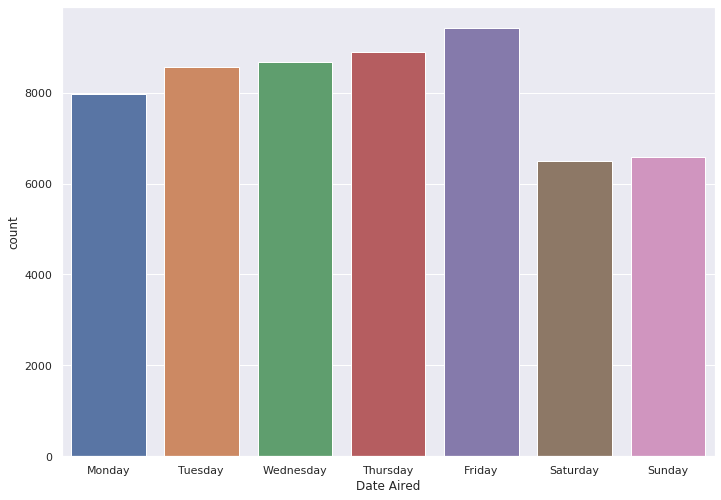

In [66]:
ax = sns.countplot(x=training["Date Aired"].dt.day_name(), data=dat)

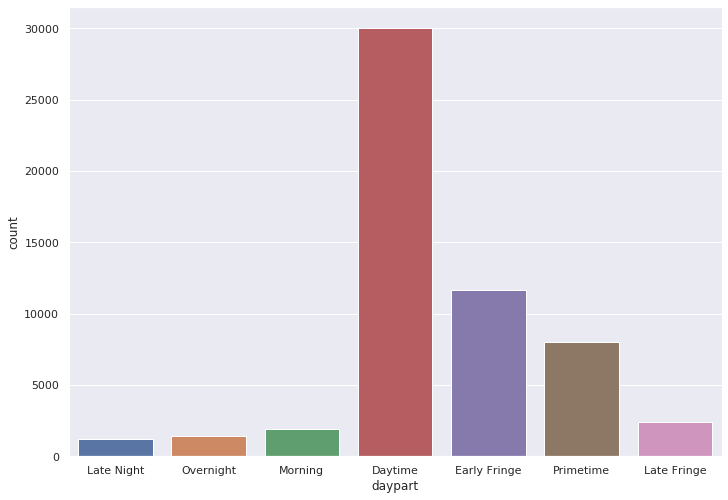

In [67]:
ax = sns.countplot(x=training["daypart"], data=dat)

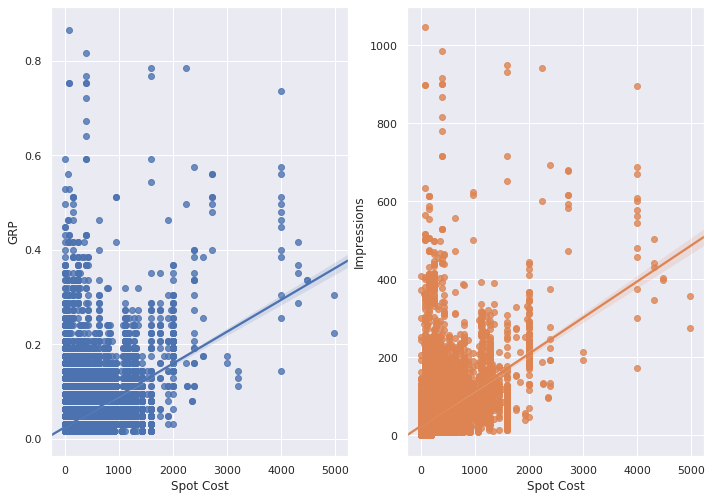

In [68]:
fig, ax = plt.subplots(1, 2)
sns.regplot(x=training["Spot Cost"], y=training["GRP"], data=training, ax=ax[0])
sns.regplot(x=training["Spot Cost"], y=training["Impressions"], data=training, ax=ax[1])

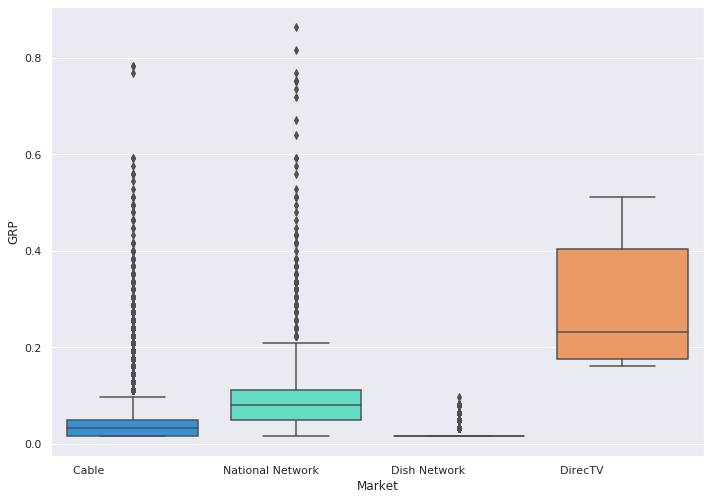

In [69]:
sns.boxplot(x=training["Market"], y=training["GRP"], data=training, palette="rainbow")

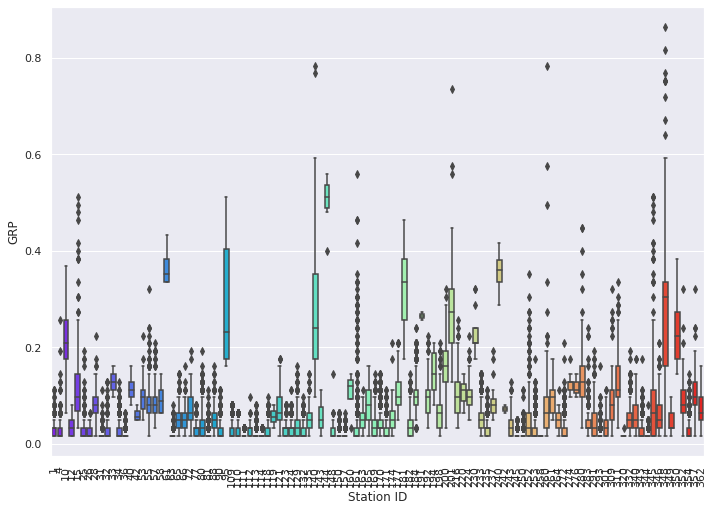

In [70]:
box = sns.boxplot(x=training["Station ID"], y=training["GRP"], data=training, palette="rainbow")
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

## Model Training

### Linear Regression

In [80]:
outliers = pd.read_pickle('outlier_stations.pickle')

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
outlier_stations

[216, 184, 352, 311, 200, 10, 15, 192, 224, 280, 252, 72]

In [81]:
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Access"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"], drop_first=True)], axis=1)

dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat.columns

KeyError: 'Station ID'

In [ ]:
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))
dat.columns

In [ ]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

labels = [
        "Length",
        "Spot_Cost",
        "Q219",
        "Q319",
        "Q419",
        "15GD",
        "15PN",
        "30BP",
        "30DE",
        "30DP",
        "30GD",
        "30GX",
        "30PL",
        "30PM",
        "30PT",
        "30SR",
        "30TN",
        "30VE",
        "SV15",
        "DirecTV",
        "Dish_Network",
        "National_Network",
        "Over-the-top_content",
        "Sunday",
        "Thursday",
        "Tuesday",
        "Wednesday",
        "Early_Fringe",
        "Late_Fringe",
        "Late_Night",
        "Morning",
        "Overnight",
        "Primetime",
        "is_outlier"
    ]

X = training.loc[:,labels]
y = training.loc[:, "Impressions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
lr = sm.OLS(y_train, X_train).fit()

lr_preds = lr.predict(X_test)

lr_mse = MSE(y_test, lr_preds)
lr_mse

In [78]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GRP   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     849.0
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:05:59   Log-Likelihood:                 86108.
No. Observations:               42430   AIC:                        -1.722e+05
Df Residuals:                   42397   BIC:                        -1.719e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Length                   0.0017      0.000     11.865      0.000       0.001       0.002
Spot_Cost              6.19e-05   6.64e-07     93.234      0.000    6.06e-05    6.32e-05
Q219                     0.0003      0.000      1.130      0.258      -0.000       0.001
Q219                     0.0003      0.000      1.130      0.258      -0.000       0.001
Q319                     0.0015      0.000      5.484      0.000       0.001       0.002
Q319                     0.0015      0.000      5.484      0.000       0.001       0.002
Q419                    -0.0016      0.000     -5.656      0.000      -0.002      -0.001
Q419                    -0.0016      0.000     -5.656      0.000      -0.002      -0.001
15GD                    -0.0006      0.001     -0.476      0.634      -0.003       0.002
15GD                    -0.0006      0.001     -0.476      0.634      -0.003       0.002
15PN                     0.0022      0.001      1.510      0.131      -0.001       0.005
15PN                     0.0022      0.001      1.510      0.131      -0.001       0.005
30BP                    -0.0207      0.002     -9.255      0.000      -0.025      -0.016
30BP                    -0.0207      0.002     -9.255      0.000      -0.025      -0.016
30DE                    -0.0151      0.003     -5.183      0.000      -0.021      -0.009
30DE                    -0.0151      0.003     -5.183      0.000      -0.021      -0.009
30DP                    -0.0098      0.002     -4.478      0.000      -0.014      -0.006
30DP                    -0.0098      0.002     -4.478      0.000      -0.014      -0.006
30GD                    -0.0175      0.002     -8.185      0.000      -0.022      -0.013
30GD                    -0.0175      0.002     -8.185      0.000      -0.022      -0.013
30GX                    -0.0149      0.002     -6.943      0.000      -0.019      -0.011
30GX                    -0.0149      0.002     -6.943      0.000      -0.019      -0.011
30PL                    -0.0149      0.002     -6.144      0.000      -0.020      -0.010
30PL                    -0.0149      0.002     -6.144      0.000      -0.020      -0.010
30PM                    -0.0141      0.002     -6.465      0.000      -0.018      -0.010
30PM                    -0.0141      0.002     -6.465      0.000      -0.018      -0.010
30PT                    -0.0166      0.002     -7.799      0.000      -0.021      -0.012
30PT                    -0.0166      0.002     -7.799      0.000      -0.021      -0.012
30SR                    -0.0088      0.002     -3.958      0.000      -0.013      -0.004
30SR                    -0.0088      0.002     -3.958      0.000      -0.013      -0.004
30TN                    -0.0171      0.003     -6.490      0.000      -0.022      -0.012
30TN                    -0.0171      0.003     -6.490    

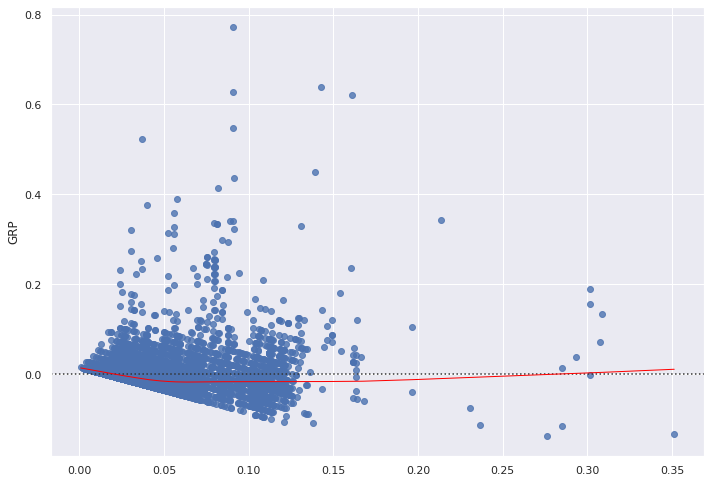

In [39]:
sns.residplot(
    lr_preds,
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

Text(0.5, 1.0, 'Normal Q-Q Plot')

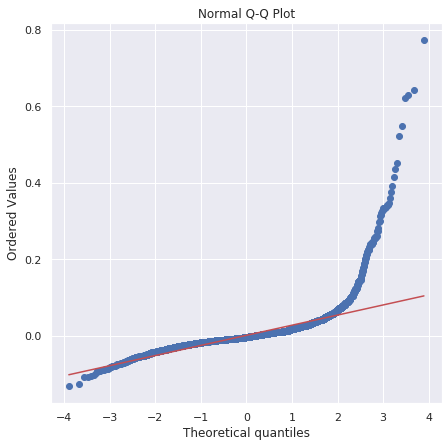

In [40]:
residuals = y_test - lr_preds
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
print(MSE(lr_preds, y_train))

### XGBoost Regressor

In [ ]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

In [ ]:
xgb_preds = xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_preds)

In [ ]:
sns.residplot(
    xgb_preds.reshape(-1),
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

In [ ]:
residuals = y_test - xgb_preds.reshape(-1)
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### Outlier Stations

In [ ]:
dat['month'] = pd.DatetimeIndex(dat['Date Aired']).month
dat['month'] = dat['month'].apply(lambda x: calendar.month_name[x])

#### Outliers by Impressions

In [ ]:
station_averages = dat.groupby(['month', 'Station ID']).mean().reindex(level=1)
monthly_averages = dat.groupby('month').mean().iloc[:, :-1]

In [ ]:
total_averages = station_averages.join(monthly_averages,
                                       on='month', rsuffix='_monthly_averages')

#### Example 1: Find outlier stations in January using January average for Impressions

In [ ]:
january = total_averages.iloc[total_averages.index.get_level_values('month')=='January']
january = january[january['Impressions'].notnull() & january['Impressions']>0]
january['outliers'] = np.where(january['Impressions'] < 2*january['Impressions'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['Impressions'], 
                  data=january, palette=sns.color_palette(), hue='outliers')
line = box.axhline(2*january['Impressions'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

#### Example 2: Using GRP

In [ ]:
january['outliers_grp'] = np.where(january['GRP'] < 2*january['GRP'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['GRP'], 
                  data=january, palette=sns.color_palette(), hue='outliers_grp')
line = box.axhline(2*january['GRP'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
january[(january.outliers == True) & (january.outliers_grp == True)]